# Named Entity Recognition - Exploratory Data Analysis

This notebook explores the training data, performs data cleaning, and creates train/validation splits for the NER contest.

## Objectives:
1. Load and explore training data
2. Analyze entity distribution and statistics
3. Identify data quality issues
4. Create train/validation split
5. Save processed data for modeling

In [39]:
# Import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [40]:
# Load training data
def load_jsonl(file_path):
    """Load JSONL file into a list of dictionaries"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

train_data = load_jsonl('train_data.jsonl')
test_data = load_jsonl('test_data.jsonl')

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nExample training sample:")
print(json.dumps(train_data[0], indent=2))

Training samples: 100541
Test samples: 5000

Example training sample:
{
  "id": 1,
  "tokens": [
    "frank",
    "d.",
    "o'connor",
    "(",
    "1909",
    "\u2013",
    "1992",
    ")",
    "lawyer",
    "judge",
    "and",
    "politician",
    "\u2212",
    "head",
    "trauma"
  ],
  "ner_tags": [
    "B-Politician",
    "I-Politician",
    "I-Politician",
    "O",
    "O",
    "O",
    "O",
    "O",
    "O",
    "O",
    "O",
    "O",
    "O",
    "O",
    "O"
  ]
}


## 2. Basic Statistics

Token Length Statistics:
  Mean: 14.19
  Median: 14.00
  Min: 0
  Max: 41
  Std: 5.59


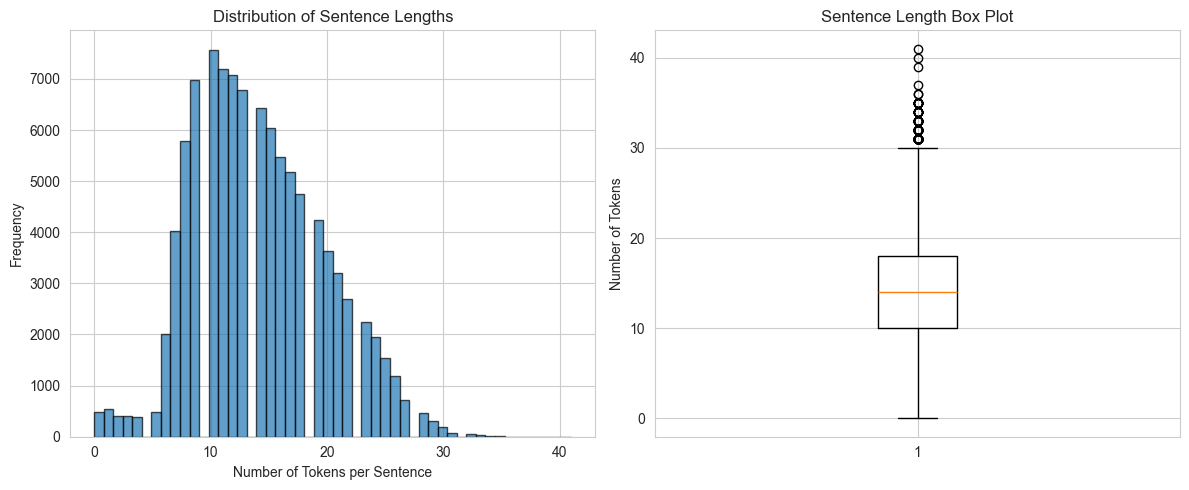

In [41]:
# Calculate basic statistics
token_lengths = [len(sample['tokens']) for sample in train_data]

print("Token Length Statistics:")
print(f"  Mean: {np.mean(token_lengths):.2f}")
print(f"  Median: {np.median(token_lengths):.2f}")
print(f"  Min: {np.min(token_lengths)}")
print(f"  Max: {np.max(token_lengths)}")
print(f"  Std: {np.std(token_lengths):.2f}")

# Plot distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(token_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Tokens per Sentence')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')

plt.subplot(1, 2, 2)
plt.boxplot(token_lengths, vert=True)
plt.ylabel('Number of Tokens')
plt.title('Sentence Length Box Plot')
plt.tight_layout()
plt.show()

## 3. Entity Label Analysis

In [42]:
# Count all NER tags
all_tags = []
for sample in train_data:
    all_tags.extend(sample['ner_tags'])

tag_counts = Counter(all_tags)
print("NER Tag Distribution:")
for tag, count in sorted(tag_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(all_tags)) * 100
    print(f"  {tag:20s}: {count:8,} ({percentage:5.2f}%)")

print(f"\nTotal tokens: {len(all_tags):,}")
print(f"Unique tags: {len(tag_counts)}")

NER Tag Distribution:
  O                   : 1,144,347 (80.24%)
  B-HumanSettlement   :   35,748 ( 2.51%)
  I-ORG               :   31,332 ( 2.20%)
  I-Artist            :   30,285 ( 2.12%)
  B-Artist            :   28,704 ( 2.01%)
  I-OtherPER          :   23,066 ( 1.62%)
  I-Facility          :   22,124 ( 1.55%)
  B-ORG               :   19,134 ( 1.34%)
  I-Politician        :   18,892 ( 1.32%)
  B-OtherPER          :   17,685 ( 1.24%)
  I-HumanSettlement   :   16,939 ( 1.19%)
  B-Facility          :   14,318 ( 1.00%)
  B-Politician        :   14,114 ( 0.99%)
  B-PublicCorp        :    5,445 ( 0.38%)
  I-PublicCorp        :    4,111 ( 0.29%)

Total tokens: 1,426,244
Unique tags: 15


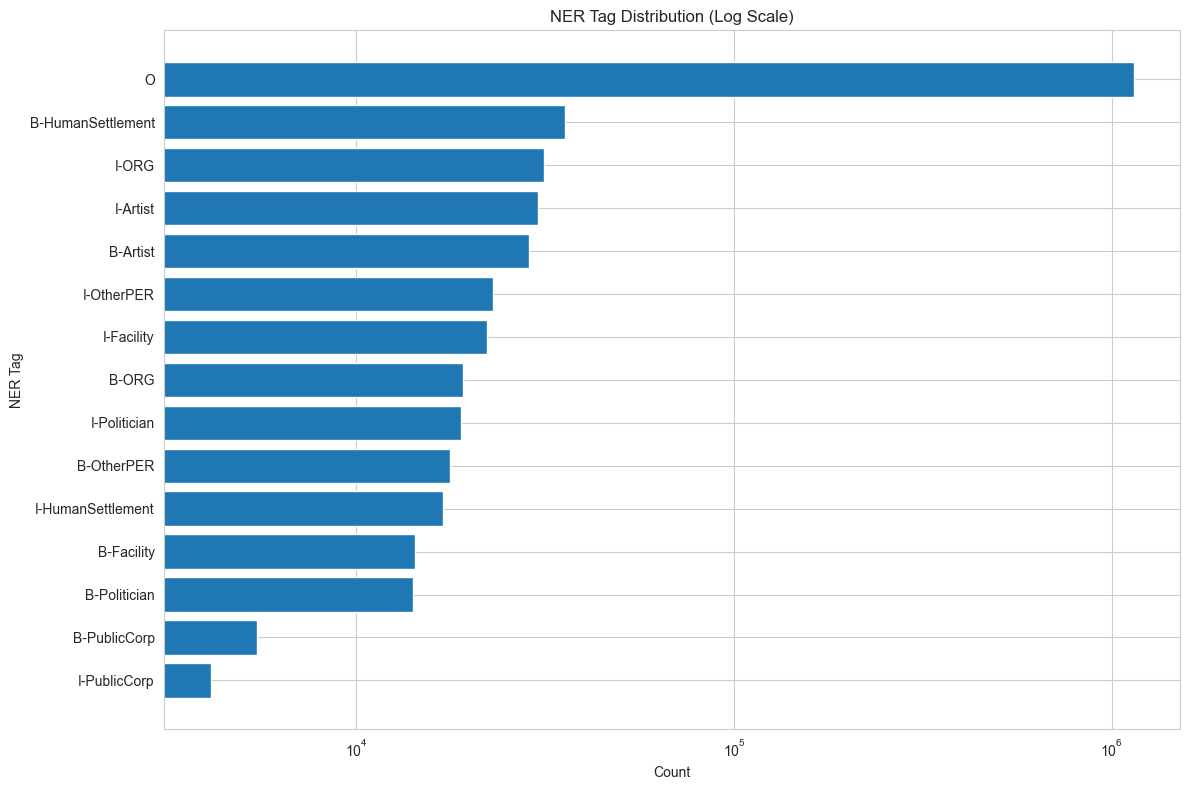

In [43]:
# Visualize tag distribution
tag_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count'])
tag_df = tag_df.sort_values('Count', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(tag_df['Tag'], tag_df['Count'])
plt.xlabel('Count')
plt.ylabel('NER Tag')
plt.title('NER Tag Distribution (Log Scale)')
plt.xscale('log')
plt.tight_layout()
plt.show()

## 4. Entity Span Analysis

Extract complete entity spans and analyze them.

In [44]:
def extract_entities(tokens, tags):
    """
    Extract entity spans from BIO tags.
    Returns list of tuples: (entity_text, entity_type, start_idx, end_idx)
    """
    entities = []
    current_entity = None
    current_tokens = []
    start_idx = None
    
    for i, (token, tag) in enumerate(zip(tokens, tags)):
        if tag.startswith('B-'):
            # Save previous entity if exists
            if current_entity:
                entities.append((
                    ' '.join(current_tokens),
                    current_entity,
                    start_idx,
                    i - 1
                ))
            # Start new entity
            current_entity = tag[2:]  # Remove 'B-' prefix
            current_tokens = [token]
            start_idx = i
        elif tag.startswith('I-'):
            # Continue current entity
            if current_entity:
                current_tokens.append(token)
        else:  # 'O' tag
            # Save previous entity if exists
            if current_entity:
                entities.append((
                    ' '.join(current_tokens),
                    current_entity,
                    start_idx,
                    i - 1
                ))
                current_entity = None
                current_tokens = []
                start_idx = None
    
    # Don't forget last entity
    if current_entity:
        entities.append((
            ' '.join(current_tokens),
            current_entity,
            start_idx,
            len(tokens) - 1
        ))
    
    return entities

# Extract all entities
all_entities = []
entity_type_counts = Counter()
entity_lengths = []

for sample in train_data:
    entities = extract_entities(sample['tokens'], sample['ner_tags'])
    all_entities.extend(entities)
    for entity_text, entity_type, start, end in entities:
        entity_type_counts[entity_type] += 1
        entity_lengths.append(end - start + 1)

print(f"Total entities: {len(all_entities):,}")
print(f"\nEntity Type Distribution:")
for entity_type, count in sorted(entity_type_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(all_entities)) * 100
    print(f"  {entity_type:20s}: {count:6,} ({percentage:5.2f}%)")

Total entities: 135,148

Entity Type Distribution:
  HumanSettlement     : 35,748 (26.45%)
  Artist              : 28,704 (21.24%)
  ORG                 : 19,134 (14.16%)
  OtherPER            : 17,685 (13.09%)
  Facility            : 14,318 (10.59%)
  Politician          : 14,114 (10.44%)
  PublicCorp          :  5,445 ( 4.03%)


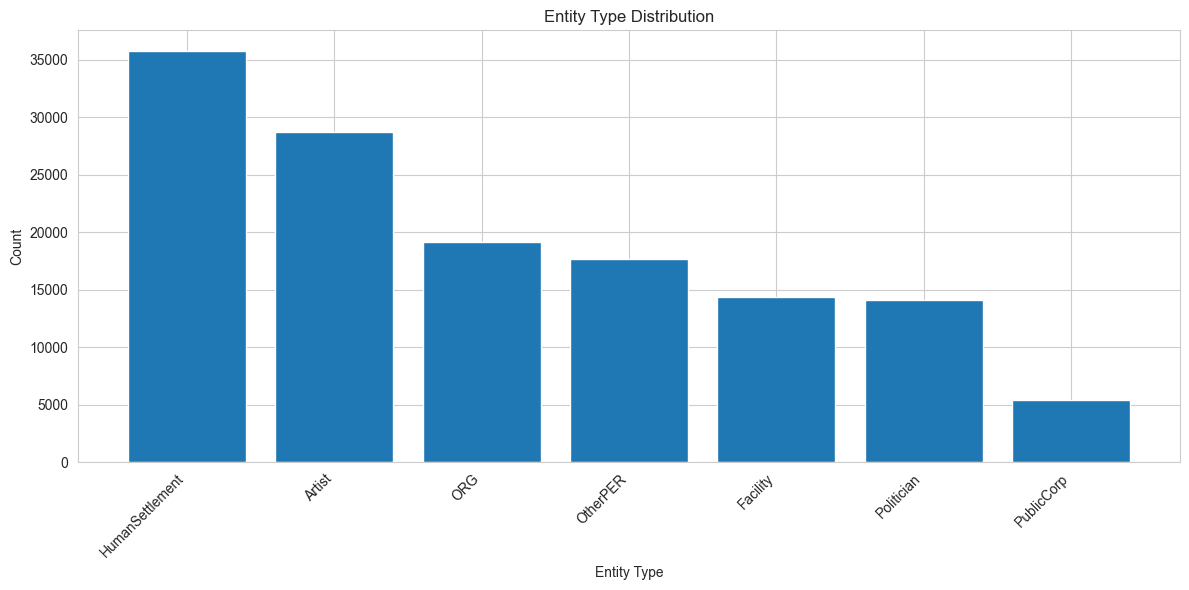

In [45]:
# Visualize entity types
entity_df = pd.DataFrame(entity_type_counts.items(), columns=['Entity Type', 'Count'])
entity_df = entity_df.sort_values('Count', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(entity_df['Entity Type'], entity_df['Count'])
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Entity Type Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Entity Span Length Statistics:
  Mean: 2.08 tokens
  Median: 2.00 tokens
  Min: 1 tokens
  Max: 19 tokens


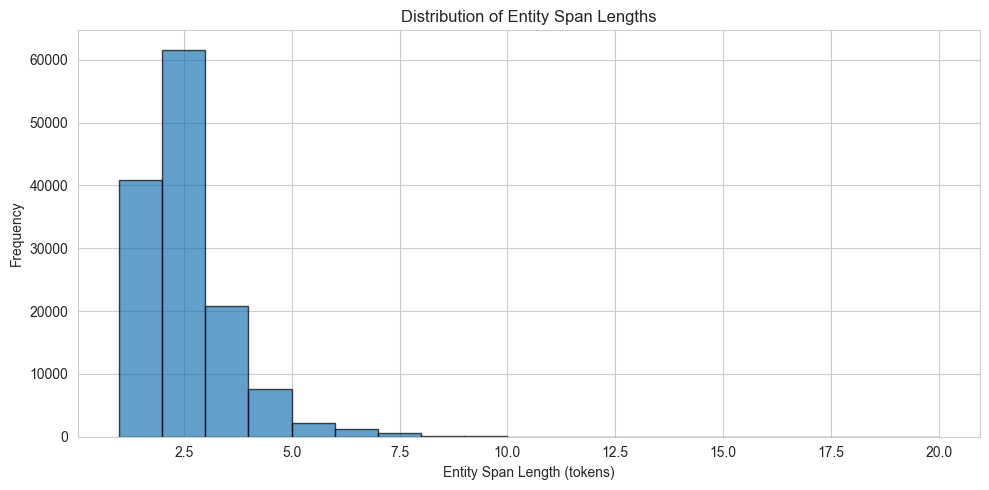

In [46]:
# Analyze entity span lengths
print("Entity Span Length Statistics:")
print(f"  Mean: {np.mean(entity_lengths):.2f} tokens")
print(f"  Median: {np.median(entity_lengths):.2f} tokens")
print(f"  Min: {np.min(entity_lengths)} tokens")
print(f"  Max: {np.max(entity_lengths)} tokens")

plt.figure(figsize=(10, 5))
plt.hist(entity_lengths, bins=range(1, max(entity_lengths) + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Entity Span Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Entity Span Lengths')
plt.tight_layout()
plt.show()

In [47]:
# Find top 5 longest entity spans
entities_with_lengths = []
for entity_text, entity_type, start, end in all_entities:
    span_length = end - start + 1
    entities_with_lengths.append((entity_text, entity_type, span_length))

# Sort by length (descending)
entities_with_lengths.sort(key=lambda x: x[2], reverse=True)

print("Top 5 Longest Entity Spans:\n")
for i, (text, entity_type, length) in enumerate(entities_with_lengths[:5], 1):
    print(f"{i}. [{entity_type}] '{text}' ({length} tokens)")


Top 5 Longest Entity Spans:

1. [HumanSettlement] 'alt=cyclists from many teams riding in the streets. a building , streetlamps and trees are shown in the background.' (19 tokens)
2. [ORG] 'armenian catholic eparchy of our lady of nareg in the united states of america and canada' (16 tokens)
3. [Artist] 'alt= laucke with his arm around the sohulder of julian bream , both smiling' (14 tokens)
4. [Politician] 'diana prince / diana themyscira / princess diana of themyscira / wonder woman' (13 tokens)
5. [Facility] 'bayburt (aydıntepe) - gümüşhane - trabzon (araklı) , salmankaş (şehit hamit şahin) tunnel' (13 tokens)


In [48]:
# Show example entities for each type
print("\nExample Entities by Type:\n")
entity_examples = defaultdict(list)
for entity_text, entity_type, _, _ in all_entities:
    if len(entity_examples[entity_type]) < 5:
        entity_examples[entity_type].append(entity_text)

for entity_type in sorted(entity_examples.keys()):
    print(f"{entity_type}:")
    for example in entity_examples[entity_type]:
        print(f"  - {example}")
    print()


Example Entities by Type:

Artist:
  - simon mayo
  - michael sgtraight
  - birendra krishna bhadra
  - tto rodrígiez
  - paul hhunter

Facility:
  - village hall
  - old cadet chapel
  - lanxess arena
  - almshouses
  - royal swedish academy of sciences

HumanSettlement:
  - busan
  - helsinki
  - cleveland , ohio
  - bulgaria
  - los angeles

ORG:
  - democrat
  - bundestag
  - united stats census bureau
  - green party of prince edward island
  - lloyd’s syndicate

OtherPER:
  - zcrny
  - warlrod
  - peter bourne
  - brutalzation of a hitian immigrant by police officers
  - edward mreyrick

Politician:
  - frank d. o'connor
  - bruce antone
  - woodrow wilson
  - siir peter warren
  - arturo toscanini

PublicCorp:
  - safeway
  - s&p global ratings
  - mcdonald 's
  - singapore airlines
  - general electric



## 5. Data Quality Checks

In [49]:
# Check for data quality issues
issues = []

for i, sample in enumerate(train_data):
    # Check if tokens and tags have same length
    if len(sample['tokens']) != len(sample['ner_tags']):
        issues.append(f"Sample {i}: Mismatched lengths - {len(sample['tokens'])} tokens vs {len(sample['ner_tags'])} tags")
    
    # Check for invalid BIO sequences (I- without B-)
    prev_tag = 'O'
    for j, tag in enumerate(sample['ner_tags']):
        if tag.startswith('I-'):
            entity_type = tag[2:]
            # I- should follow B- or I- of same type
            if not (prev_tag == f'B-{entity_type}' or prev_tag == f'I-{entity_type}'):
                issues.append(f"Sample {i}, token {j}: Invalid BIO sequence - {prev_tag} -> {tag}")
        prev_tag = tag

if issues:
    print(f"Found {len(issues)} data quality issues:\n")
    for issue in issues[:10]:  # Show first 10
        print(f"  - {issue}")
    if len(issues) > 10:
        print(f"  ... and {len(issues) - 10} more")
else:
    print("No data quality issues found!")

Found 185 data quality issues:

  - Sample 538, token 0: Invalid BIO sequence - O -> I-Artist
  - Sample 1884, token 0: Invalid BIO sequence - O -> I-Artist
  - Sample 2303, token 0: Invalid BIO sequence - O -> I-Facility
  - Sample 2845, token 0: Invalid BIO sequence - O -> I-OtherPER
  - Sample 3210, token 0: Invalid BIO sequence - O -> I-Politician
  - Sample 3294, token 0: Invalid BIO sequence - O -> I-OtherPER
  - Sample 3849, token 0: Invalid BIO sequence - O -> I-ORG
  - Sample 4943, token 0: Invalid BIO sequence - O -> I-Artist
  - Sample 5215, token 0: Invalid BIO sequence - O -> I-Facility
  - Sample 5739, token 0: Invalid BIO sequence - O -> I-Politician
  ... and 175 more


In [50]:
# Print detailed information about problematic samples
print("Detailed View of Problematic Samples:\n")
print("=" * 80)

problematic_sample_ids = set()
for issue in issues[:10]:
    # Extract sample ID from issue string (handle both formats)
    if "Sample " in issue:
        sample_id_str = issue.split("Sample ")[1].split(",")[0].split(":")[0]
        sample_id = int(sample_id_str)
        problematic_sample_ids.add(sample_id)

for sample_id in sorted(list(problematic_sample_ids))[:10]:
    sample = train_data[sample_id]
    print(f"\nSample ID: {sample_id}")
    print(f"Tokens ({len(sample['tokens'])}): {sample['tokens']}")
    print(f"Tags ({len(sample['ner_tags'])}): {sample['ner_tags']}")
    
    # Show which issues this sample has
    sample_issues = [issue for issue in issues if f"Sample {sample_id}" in issue]
    print(f"Issues ({len(sample_issues)}):")
    for issue in sample_issues:
        print(f"  - {issue}")
    
    # Visualize alignment
    print("\nToken-Tag Alignment:")
    for i, (token, tag) in enumerate(zip(sample['tokens'], sample['ner_tags'])):
        marker = " ⚠️" if any(f"token {i}" in issue for issue in sample_issues) else ""
        print(f"  {i:3d}: {token:20s} -> {tag:20s}{marker}")
    
    print("-" * 80)

Detailed View of Problematic Samples:


Sample ID: 538
Tokens (2): ['hutchins', '.']
Tags (2): ['I-Artist', 'O']
Issues (1):
  - Sample 538, token 0: Invalid BIO sequence - O -> I-Artist

Token-Tag Alignment:
    0: hutchins             -> I-Artist             ⚠️
    1: .                    -> O                   
--------------------------------------------------------------------------------

Sample ID: 1884
Tokens (5): ['kane', 'and', 'dom', 'deluise', '.']
Tags (5): ['I-Artist', 'O', 'B-Artist', 'I-Artist', 'O']
Issues (1):
  - Sample 1884, token 0: Invalid BIO sequence - O -> I-Artist

Token-Tag Alignment:
    0: kane                 -> I-Artist             ⚠️
    1: and                  -> O                   
    2: dom                  -> B-Artist            
    3: deluise              -> I-Artist            
    4: .                    -> O                   
--------------------------------------------------------------------------------

Sample ID: 2303
Tokens (5): ['roll',

## 6. Sentences with/without Entities

Sentences with entities: 97,229 (96.71%)
Sentences without entities: 3,312 (3.29%)

Entities per sentence:
  Mean: 1.34
  Median: 1.00
  Max: 11


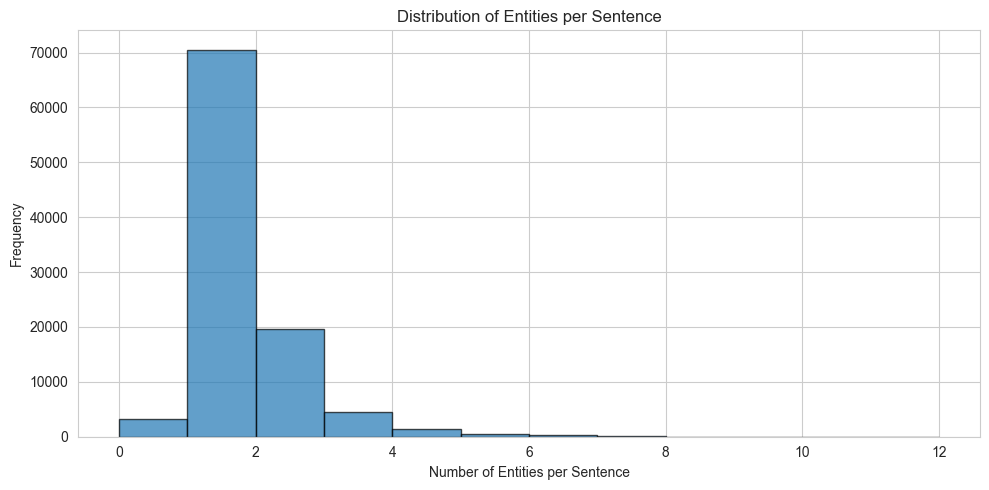

In [51]:
# Count sentences with and without entities
sentences_with_entities = 0
sentences_without_entities = 0
entities_per_sentence = []

for sample in train_data:
    entities = extract_entities(sample['tokens'], sample['ner_tags'])
    num_entities = len(entities)
    entities_per_sentence.append(num_entities)
    
    if num_entities > 0:
        sentences_with_entities += 1
    else:
        sentences_without_entities += 1

print(f"Sentences with entities: {sentences_with_entities:,} ({sentences_with_entities/len(train_data)*100:.2f}%)")
print(f"Sentences without entities: {sentences_without_entities:,} ({sentences_without_entities/len(train_data)*100:.2f}%)")
print(f"\nEntities per sentence:")
print(f"  Mean: {np.mean(entities_per_sentence):.2f}")
print(f"  Median: {np.median(entities_per_sentence):.2f}")
print(f"  Max: {np.max(entities_per_sentence)}")

plt.figure(figsize=(10, 5))
plt.hist(entities_per_sentence, bins=range(0, max(entities_per_sentence) + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Entities per Sentence')
plt.ylabel('Frequency')
plt.title('Distribution of Entities per Sentence')
plt.tight_layout()
plt.show()

In [52]:
# Find and display sentences without entities
sentences_without_entities_list = []

for sample in train_data:
    entities = extract_entities(sample['tokens'], sample['ner_tags'])
    if len(entities) == 0:
        sentences_without_entities_list.append(sample)

print(f"Total sentences without entities: {len(sentences_without_entities_list):,}\n")
print("=" * 80)
print("Sample Sentences WITHOUT Entities (showing first 20):\n")

for i, sample in enumerate(sentences_without_entities_list[:20], 1):
    sentence_text = ' '.join(sample['tokens'])
    print(f"{i}. [ID: {sample['id']}] {sentence_text}")
    print()

# Show statistics
if sentences_without_entities_list:
    no_entity_lengths = [len(s['tokens']) for s in sentences_without_entities_list]
    print("=" * 80)
    print("Statistics for sentences WITHOUT entities:")
    print(f"  Count: {len(sentences_without_entities_list):,}")
    print(f"  Mean length: {np.mean(no_entity_lengths):.2f} tokens")
    print(f"  Min length: {np.min(no_entity_lengths)} tokens")
    print(f"  Max length: {np.max(no_entity_lengths)} tokens")

Total sentences without entities: 3,312

Sample Sentences WITHOUT Entities (showing first 20):

1. [ID: 2] it also offers study tools and dictionary and thesaurus entries from

2. [ID: 116] .

3. [ID: 154] also included are

4. [ID: 193] three wheeler era in greece )

5. [ID: 232] 

6. [ID: 307] it is found only in

7. [ID: 349] 1980s .

8. [ID: 386] it is near the cemtre

9. [ID: 389] palladino

10. [ID: 405] .

11. [ID: 433] on the

12. [ID: 468] file : coat of arms

13. [ID: 539] hutchins .

14. [ID: 582] he

15. [ID: 586] 1939 .

16. [ID: 661] collars .

17. [ID: 704] the 2019 – 20 season .

18. [ID: 710] siena

19. [ID: 712] the

20. [ID: 714] one of the best films of 2014 .

Statistics for sentences WITHOUT entities:
  Count: 3,312
  Mean length: 4.56 tokens
  Min length: 0 tokens
  Max length: 26 tokens


## 7. Train/Validation Split (+ data cleaning)

Create stratified split to maintain entity distribution in both sets.

In [53]:
# ============================================================================
# DATA CLEANING
# ============================================================================

print("=" * 80)
print("DATA CLEANING")
print("=" * 80)

# Store original counts
original_count = len(train_data)
print(f"\nOriginal training samples: {original_count:,}")

# Identify samples with invalid BIO sequences
invalid_sample_ids = set()

for i, sample in enumerate(train_data):
    prev_tag = 'O'
    has_issue = False
    for j, tag in enumerate(sample['ner_tags']):
        if tag.startswith('I-'):
            entity_type = tag[2:]
            # Check if I- follows B- or I- of same type
            if not (prev_tag == f'B-{entity_type}' or prev_tag == f'I-{entity_type}'):
                has_issue = True
                break
        prev_tag = tag
    
    if has_issue:
        invalid_sample_ids.add(i)

print(f"Samples with invalid BIO sequences: {len(invalid_sample_ids)}")

# Show examples before removing
if len(invalid_sample_ids) > 0:
    print("\nExamples of samples to be removed (first 5):\n")
    for i, idx in enumerate(sorted(list(invalid_sample_ids))[:5], 1):
        sample = train_data[idx]
        print(f"{i}. Sample ID {sample['id']}:")
        print(f"   Tokens: {sample['tokens'][:15]}")  # Show first 15 tokens
        print(f"   Tags:   {sample['ner_tags'][:15]}")
        print()

# Remove invalid samples
train_data_cleaned = [sample for i, sample in enumerate(train_data) if i not in invalid_sample_ids]

# Update train_data to cleaned version
train_data = train_data_cleaned

# Check for empty sentences (keep them since test has them)
empty_count = sum(1 for sample in train_data if len(sample['tokens']) == 0)
print(f"Empty sentences (0 tokens): {empty_count} - KEPT (test has empty sentences)")

# Check sentences without entities (keep them for balance)
no_entity_count = sum(1 for sample in train_data if all(tag == 'O' for tag in sample['ner_tags']))
print(f"Sentences without entities: {no_entity_count:,} - KEPT (needed for O tag learning)")

# Verify no invalid sequences remain
remaining_issues = 0
for sample in train_data:
    prev_tag = 'O'
    for tag in sample['ner_tags']:
        if tag.startswith('I-'):
            entity_type = tag[2:]
            if not (prev_tag == f'B-{entity_type}' or prev_tag == f'I-{entity_type}'):
                remaining_issues += 1
        prev_tag = tag

print(f"\nRemaining invalid sequences: {remaining_issues}")

# Summary
print(f"\n{'='*80}")
print("CLEANING SUMMARY:")
print(f"{'='*80}")
print(f"Original samples:           {original_count:,}")
print(f"Samples after cleaning:     {len(train_data):,}")
print(f"Samples removed:            {len(invalid_sample_ids):,} ({len(invalid_sample_ids)/original_count*100:.3f}%)")
print(f"Empty sentences kept:       {empty_count}")
print(f"No-entity sentences kept:   {no_entity_count:,}")
print(f"{'='*80}\n")

DATA CLEANING

Original training samples: 100,541
Samples with invalid BIO sequences: 185

Examples of samples to be removed (first 5):

1. Sample ID 539:
   Tokens: ['hutchins', '.']
   Tags:   ['I-Artist', 'O']

2. Sample ID 1885:
   Tokens: ['kane', 'and', 'dom', 'deluise', '.']
   Tags:   ['I-Artist', 'O', 'B-Artist', 'I-Artist', 'O']

3. Sample ID 2304:
   Tokens: ['roll', 'hall', 'of', 'fame', '.']
   Tags:   ['I-Facility', 'I-Facility', 'I-Facility', 'I-Facility', 'O']

4. Sample ID 2846:
   Tokens: ['lujd', 'chairman', 'of', 'bp', 'and', 'novo', 'nordisk', '.']
   Tags:   ['I-OtherPER', 'O', 'O', 'B-PublicCorp', 'O', 'B-PublicCorp', 'I-PublicCorp', 'O']

5. Sample ID 3211:
   Tokens: ['mill', 'which', 'led', 'to', 'a', 'lifelong', 'friendship', '.']
   Tags:   ['I-Politician', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Empty sentences (0 tokens): 479 - KEPT (test has empty sentences)
Sentences without entities: 3,177 - KEPT (needed for O tag learning)

Remaining invalid sequences: 0



In [54]:
# Create stratification labels based on presence of entities
stratify_labels = []
for sample in train_data:
    # Create label based on whether sentence has entities
    has_entities = any(tag != 'O' for tag in sample['ner_tags'])
    stratify_labels.append(int(has_entities))

# Split data (90% train, 10% validation)
train_samples, val_samples = train_test_split(
    train_data,
    test_size=0.1,
    random_state=42,
    stratify=stratify_labels
)

print(f"Training samples: {len(train_samples):,}")
print(f"Validation samples: {len(val_samples):,}")
print(f"Test samples: {len(test_data):,}")

Training samples: 90,320
Validation samples: 10,036
Test samples: 5,000


In [55]:
# Verify entity distribution in splits
def get_entity_type_distribution(data):
    """Get entity type distribution for a dataset"""
    entity_counts = Counter()
    for sample in data:
        entities = extract_entities(sample['tokens'], sample['ner_tags'])
        for _, entity_type, _, _ in entities:
            entity_counts[entity_type] += 1
    return entity_counts

train_entity_dist = get_entity_type_distribution(train_samples)
val_entity_dist = get_entity_type_distribution(val_samples)

print("\nEntity Type Distribution Comparison:\n")
print(f"{'Entity Type':<20} {'Train':<10} {'Val':<10} {'Train %':<10} {'Val %':<10}")
print("-" * 60)

for entity_type in sorted(train_entity_dist.keys()):
    train_count = train_entity_dist[entity_type]
    val_count = val_entity_dist[entity_type]
    train_pct = train_count / sum(train_entity_dist.values()) * 100
    val_pct = val_count / sum(val_entity_dist.values()) * 100
    print(f"{entity_type:<20} {train_count:<10,} {val_count:<10,} {train_pct:<10.2f} {val_pct:<10.2f}")


Entity Type Distribution Comparison:

Entity Type          Train      Val        Train %    Val %     
------------------------------------------------------------
Artist               25,817     2,849      21.23      21.14     
Facility             12,827     1,487      10.55      11.04     
HumanSettlement      32,261     3,476      26.53      25.80     
ORG                  17,235     1,893      14.17      14.05     
OtherPER             15,897     1,779      13.07      13.20     
Politician           12,711     1,402      10.45      10.40     
PublicCorp           4,854      589        3.99       4.37      


## 8. Save Processed Data

In [56]:
# Save train/val splits
def save_jsonl(data, file_path):
    """Save list of dictionaries to JSONL file"""
    with open(file_path, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

save_jsonl(train_samples, 'train_split.jsonl')
save_jsonl(val_samples, 'val_split.jsonl')

print("Saved processed data:")
print(f"  - train_split.jsonl ({len(train_samples):,} samples)")
print(f"  - val_split.jsonl ({len(val_samples):,} samples)")

Saved processed data:
  - train_split.jsonl (90,320 samples)
  - val_split.jsonl (10,036 samples)


## 9. Summary Statistics for Report

In [57]:
print("=" * 80)
print("SUMMARY STATISTICS FOR REPORT")
print("=" * 80)

print(f"\nDataset Size:")
print(f"  Training: {len(train_samples):,} samples")
print(f"  Validation: {len(val_samples):,} samples")
print(f"  Test: {len(test_data):,} samples")

print(f"\nEntity Types: {len(entity_type_counts)}")
for entity_type, count in sorted(entity_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {entity_type}: {count:,}")

print(f"\nToken Statistics:")
print(f"  Mean sentence length: {np.mean(token_lengths):.1f} tokens")
print(f"  Max sentence length: {np.max(token_lengths)} tokens")

print(f"\nEntity Statistics:")
print(f"  Total entities: {len(all_entities):,}")
print(f"  Mean entities per sentence: {np.mean(entities_per_sentence):.2f}")
print(f"  Mean entity span length: {np.mean(entity_lengths):.2f} tokens")

print(f"\nClass Imbalance:")
o_count = tag_counts['O']
entity_tag_count = sum(count for tag, count in tag_counts.items() if tag != 'O')
print(f"  O (outside): {o_count:,} ({o_count/len(all_tags)*100:.2f}%)")
print(f"  Entity tags: {entity_tag_count:,} ({entity_tag_count/len(all_tags)*100:.2f}%)")

print("\n" + "=" * 80)

SUMMARY STATISTICS FOR REPORT

Dataset Size:
  Training: 90,320 samples
  Validation: 10,036 samples
  Test: 5,000 samples

Entity Types: 7
  HumanSettlement: 35,748
  Artist: 28,704
  ORG: 19,134
  OtherPER: 17,685
  Facility: 14,318
  Politician: 14,114
  PublicCorp: 5,445

Token Statistics:
  Mean sentence length: 14.2 tokens
  Max sentence length: 41 tokens

Entity Statistics:
  Total entities: 135,148
  Mean entities per sentence: 1.34
  Mean entity span length: 2.08 tokens

Class Imbalance:
  O (outside): 1,144,347 (80.24%)
  Entity tags: 281,897 (19.76%)

